# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.

---
## Step 0: Load The Data

In [1]:
# code block 1
# Load pickled input data

import pickle
training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_r, y_train_r = train['features'], train['labels']
X_valid_r, y_valid_r = valid['features'], valid['labels']
X_test_r, y_test_r = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [6]:
# code block 2
# basic data summary

import numpy as np
n_train = len(X_train_r)
n_valid = len(X_valid_r)
n_test = len(X_test_r)
image_shape = X_train_r[0].shape
n_classes = len(np.unique(y_train_r))

print("Exploring Data set:")
print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of Traffic Signs (class) =", n_classes)
print("y_train.shape = ", y_train_r.shape)

Exploring Data set:
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of Traffic Signs (class) = 43
y_train.shape =  (34799,)


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

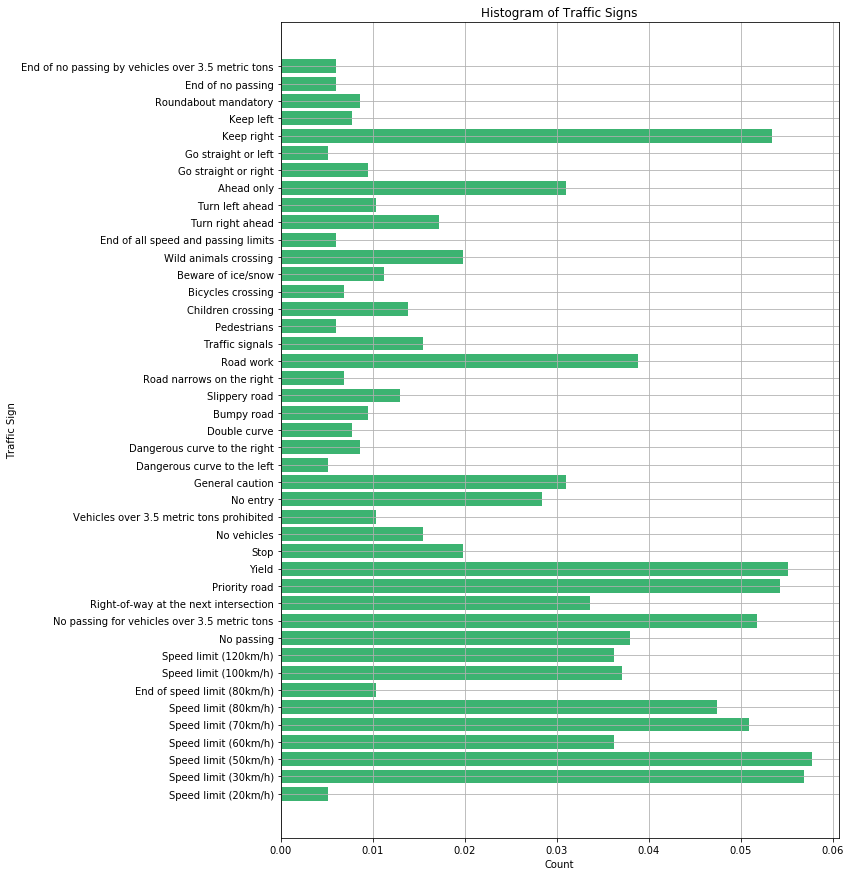

Most common road signs:
 2 Speed limit (50km/h)
 1 Speed limit (30km/h)
 13 Yield
 12 Priority road
 38 Keep right

Least common road signs:
 0 Speed limit (20km/h)
 37 Go straight or left
 19 Dangerous curve to the left
 32 End of all speed and passing limits
 27 Pedestrians


Sample Road Signs from Training set:


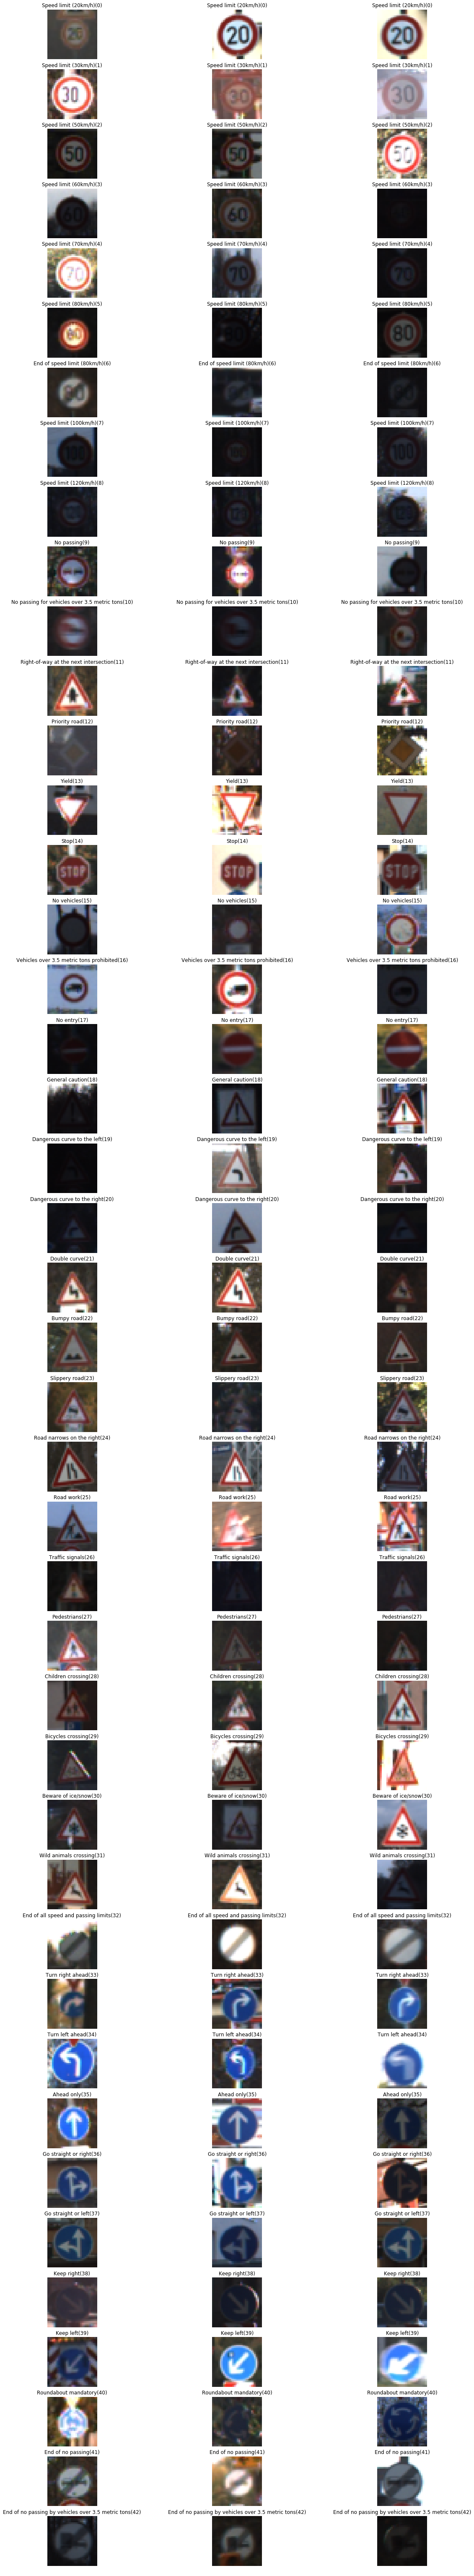

In [7]:
# code block 3
### Data exploration visualization code

%matplotlib inline

import matplotlib.pyplot as plt
from numpy import genfromtxt
from random import randint

# Visualizations will be shown in the notebook.
counts = np.bincount(y_train_r)
_signnames = genfromtxt('signnames.csv', delimiter=',', skip_header=1, dtype=[('myint','i8'),('mystring','S100')])
signnames = [s[1].decode('UTF-8') for s in _signnames]


classes = np.unique(y_train_r)
fig = plt.figure(figsize=(10,15))
plt.hist(y_train_r, bins=n_classes, align='left', normed=1, 
         color='mediumseagreen', rwidth=0.8, orientation='horizontal', 
         range=(0,n_classes))
plt.ylabel('Traffic Sign')
plt.grid(True)
plt.xlabel('Count')
plt.yticks(classes, signnames, rotation='horizontal')
plt.title("Histogram of Traffic Signs")
plt.show()

print("Most common road signs:")
print("","\n ".join([str(s) + " " + signnames[s] for s in counts.argsort()[-5:][::-1]]))
print("")
print("Least common road signs:")
print("","\n ".join([str(s) + " " + signnames[s] for s in counts.argsort()[:5]]))
print("\n")

# Plot random signs
print("Sample Road Signs from Training set:")
per_row = 3
fig = plt.figure(figsize=(20, 120))
for i in range(n_classes):
    imgs = X_train_r[y_train_r == i]
    for y in range(per_row):
        idx = randint(0, len(imgs)-1)
        a = fig.add_subplot(n_classes+3, per_row, i*per_row+y+1)
        plt.imshow(imgs[idx])
        plt.title(signnames[i] + "(" + str(i) + ")")
        plt.axis('off')
    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
# code block 4

import os
pickle_file = 'processed_images.p'
try:
    os.remove(pickle_file)
except FileNotFoundError as e:
    pass

In [10]:
# code block 5
# Preprocessing the input data
# Preprocessing steps  include normalization

from sklearn.preprocessing import LabelBinarizer as sk_LabelBinarizer                                                                                                                                       
from sklearn.utils import shuffle
import cv2 

n_depth = 3

X_train_r, y_train_r = shuffle(X_train_r, y_train_r)

def _encode(encoder, labels):
    return encoder.transform(labels).astype(np.float32)


def minmaxscale_image(image_data, a=0.1, b=0.9):                                                                                                                                                          
    grayscale_min = 0                                                                                                                                                                                       
    grayscale_max = 255                                                                                                                                                                                     
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

def rgb2gray(rgb):
    global n_depth
    n_depth = 1
    rv = np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    return np.reshape(rv, [len(rv), 32, 32, 1])


def cv2_normalize(image_data):
    imgs=[]
    zeros = np.zeros((32,32,3))
    for i in image_data:
        norm = cv2.normalize(i, zeros, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        imgs.append(norm)
    return np.array(imgs)

#img_mu  = None
#img_std = None
def _preprocess(image):
    #== standardization ==
    #global img_mu, img_std
    #img, mu, std = standardize_image(image, mu=img_mu, std=img_std)
    #if img_mu is None:
    #    img_mu = mu
    #    img_std = std

    #== minmaxscale ==    
    #img = minmaxscale_image(image)
    
    #== cvs_normalize ==
    img = cv2_normalize(image)
    
    # return the processed images
    return img
    
def prepare_data():
    # prepare images: hsv, normalize
    global X_train_r, y_train_r, X_valid_r, y_valid_r, X_test_r, y_test_r

    X_train = _preprocess(X_train_r)
    X_valid = _preprocess(X_valid_r)
    X_test  = _preprocess(X_test_r)

    # #encode training and test labels
    # encoder = sk_LabelBinarizer()
    # encoder.fit(y_train)
    # y_train = _encode(encoder, y_train)
    # y_valid = _encode(encoder, y_valid)
    # y_test = _encode(encoder, y_test)

    return {
            "x_train": X_train, 
            "y_train": y_train_r,
            "x_valid": X_valid,
            "y_valid": y_valid_r,
            "x_test": X_test,
            "y_test": y_test_r
         }

def load_data():
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file...')
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(prepare_data(), pfile, pickle.HIGHEST_PROTOCOL)
        print('saved data to pickle file...')
                                                                                                                                                                                                            
    # load cached data
    with open(pickle_file, 'rb') as pf:
        print('loading data from pickle file...')
        pd = pickle.load(pf)
        x1 = pd["x_train"]
        y1 = pd["y_train"]
        x2 = pd["x_valid"]
        y2 = pd["y_valid"]
        x3 = pd["x_test"]
        y3 = pd["y_test"]
        del pd
        print('loaded data from pickle file...')

    return x1, y1, x2, y2, x3, y3


X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()

Saving data to pickle file...
saved data to pickle file...
loading data from pickle file...
loaded data from pickle file...


y_train.shape =  (34799,)
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Sample processed images:


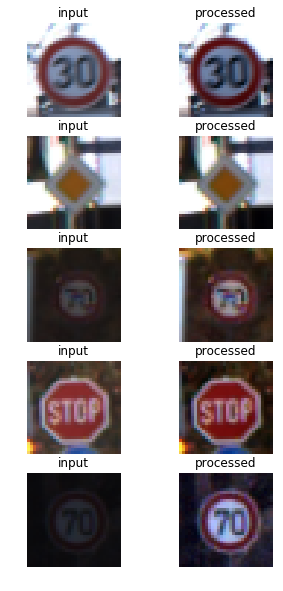

In [16]:
# code block 6

n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
print("y_train.shape = ", y_train.shape)
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("\n")
# Plot random signs
print("Sample processed images:")
fig = plt.figure(figsize=(5, 10))
for y in range(5):
    idx = randint(0, len(X_train_r))
    a = fig.add_subplot(5, 2, y*2+1)
    plt.imshow(X_train_r[idx])
    plt.title("input")
    plt.axis('off')
    
    a = fig.add_subplot(5, 2, y*2+2)
    plt.imshow(X_train[idx])
    plt.title("processed")
    plt.axis('off')
plt.show()

### Model Architecture - LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

#### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since pre-processed images are grayscale, C is 1 in this case.

#### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.
**Activation.** ReLu

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** ReLu

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** ReLu

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** ReLu

**Layer 5: Fully Connected (Logits).** This should have 43 outputs.

#### Output
Return the result of the 2nd fully connected layer.

In [17]:
# code block 7
# model


import tensorflow as tf
from tensorflow.contrib.layers import flatten
use_dropout = True

def LeNet(x, d):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    dropout = d
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # op = (inp - fh + 2*p)/s + 1
    # s(op - 1) - 2p   = inp - fh
    # s = 1, p = 0 => op - 1 = inp - fh => fh = inp - op + 1
    # 27 = 32 - fh => fh = 5
    c1W = tf.Variable(tf.truncated_normal((5, 5, n_depth, 6), mu, sigma))
    c1B = tf.Variable(tf.zeros(6))
    c1 = tf.nn.conv2d(x, c1W, [1, 1, 1, 1], 'VALID') + c1B
    # Activation.
    c1 = tf.nn.relu(c1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # op=(inp - k)/s + 1
    # inp - (op - 1)s = k
    # ~ 28 - 13s  = k
    # s = 2 => k = 2
    p1 = tf.nn.max_pool(c1, ksize=[1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')


    # Layer 2: Convolutional. Output = 10x10x16.
    # input = 14x14x6
    # fh = inp - op + 1 ~ 5
    c2W = tf.Variable(tf.truncated_normal((5, 5, 6, 16), mu, sigma))
    c2B = tf.Variable(tf.zeros(16))
    c2 = tf.nn.conv2d(p1, c2W, [1, 1, 1, 1], 'VALID') + c2B
    # TODO: Activation.
    c2 = tf.nn.relu(c2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    # inp - (op - 1)s = k
    # s = 2 => k = 10 - (5 - 1)2 = 10 - 8 = 2
    p2 = tf.nn.max_pool(c2, ksize=[1, 2, 2, 1], strides = [1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    f2 = flatten(p2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3W = tf.Variable(tf.truncated_normal((400, 120), mu, sigma))
    fc3B = tf.Variable(tf.zeros(120))
    fc3 = tf.matmul(f2, fc3W) + fc3B
    
    # Activation.
    fc3 = tf.nn.relu(fc3)
    if use_dropout:
        fc3 = tf.nn.dropout(fc3, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4W = tf.Variable(tf.truncated_normal((120, 84), mu, sigma))
    fc4B = tf.Variable(tf.zeros(84))
    fc4 = tf.matmul(fc3, fc4W) + fc4B
    
    # Activation.
    fc4 = tf.nn.relu(fc4)
    if use_dropout:
        fc4 = tf.nn.dropout(fc4, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc5W = tf.Variable(tf.truncated_normal((84, n_classes), mu, sigma))
    fc5B = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc4, fc5W) + fc5B
        
    return logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
# code block 8

import tensorflow as tf
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, n_depth))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
d = tf.placeholder(tf.float32, (None))

In [23]:
# code block 9

logits = LeNet(x, d)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [24]:
# code block 10

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, 
                                                           y: batch_y,
                                                           d: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...

0/0.699 
1/0.829 
2/0.880 
3/0.905 
4/0.911 
5/0.921 
6/0.918 
7/0.928 
8/0.926 
9/0.941 
10/0.934 
11/0.939 
12/0.938 
13/0.941 
14/0.943 
15/0.943 
16/0.943 
17/0.938 
18/0.945 
19/0.946 
20/0.951 
21/0.950 
22/0.947 
23/0.947 
24/0.950 
25/0.949 
26/0.948 
27/0.948 
28/0.948 
29/0.946 
30/0.944 
31/0.941 
32/0.940 
33/0.948 
34/0.948 
35/0.951 
36/0.955 
37/0.953 
38/0.954 
39/0.952 
40/0.954 
41/0.945 
42/0.950 
43/0.951 
44/0.947 
45/0.946 
46/0.951 
47/0.951 
48/0.956 
49/0.960 
Model saved


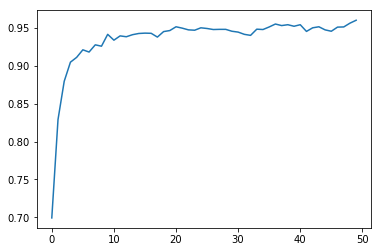

In [25]:
# code block 11

from sklearn.utils import shuffle
plot_data=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y,
                                                    d: 0.75 })
            
        validation_accuracy = evaluate(X_valid, y_valid)
        plot_data.append(validation_accuracy)
        print("{}/{:.3f}".format(i, validation_accuracy), end=' ')
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
plt.plot(range(EPOCHS),plot_data)
plt.show()

In [26]:
# code block 12

plt.plot(range(EPOCHS),plot_data)
plt.savefig('training_rate.png')
plt.close()

In [27]:
# code block 13

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [28]:
# code block 14


from PIL import Image
import glob
imagenames = glob.glob('web-german-traffic-signs/*.jpg')
X_web = np.array([np.array(Image.open(f).resize((32, 32))) \
                       for f in imagenames])
y_web = np.array([int(f.split("/")[1].split(" ")[0])\
                       for f in imagenames])
X_web = _preprocess(X_web)

labels: [11 18 25 28  3  9]


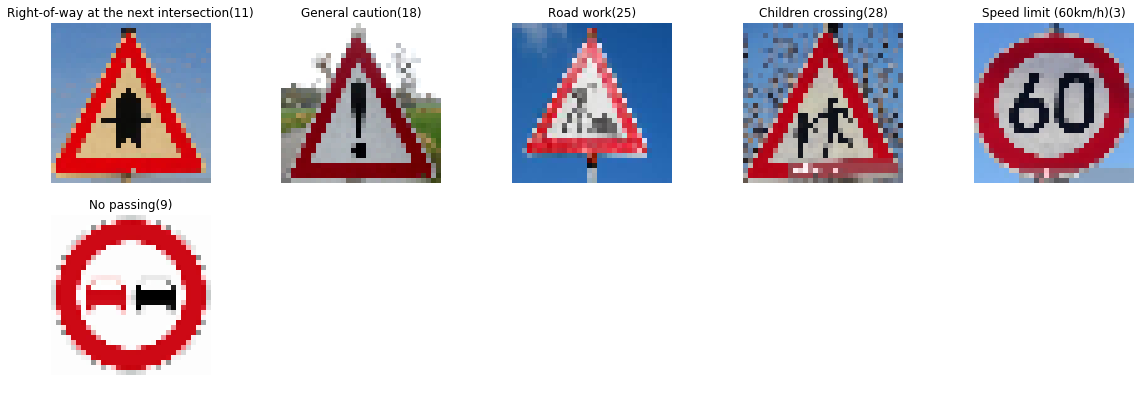

In [29]:
# code block 15

fig = plt.figure(figsize=(20, 10))
for i in range(len(imagenames)):
    a = fig.add_subplot(3, 5, i+1)
    plt.imshow(X_web[i])
    plt.title(signnames[y_web[i]] + "("+ str(y_web[i]) + ")")
    plt.axis('off')
    
print("labels:", y_web)

### Predict the Sign Type for Each Image

In [30]:
# code block 16
# Done Below

### Analyze Performance

In [33]:
# code block 17

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    preds = sess.run(tf.argmax(logits, 1), feed_dict={x:X_web, d: 1.0})
    print("Actual :     ", y_web)
    print("Predicated : ", preds)
    
    test_accuracy = evaluate(X_web, y_web)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Actual :      [11 18 25 28  3  9]
Predicated :  [11 18 25 28 38  9]
Test Accuracy = 0.833


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

Prediction Probabilities for web images:


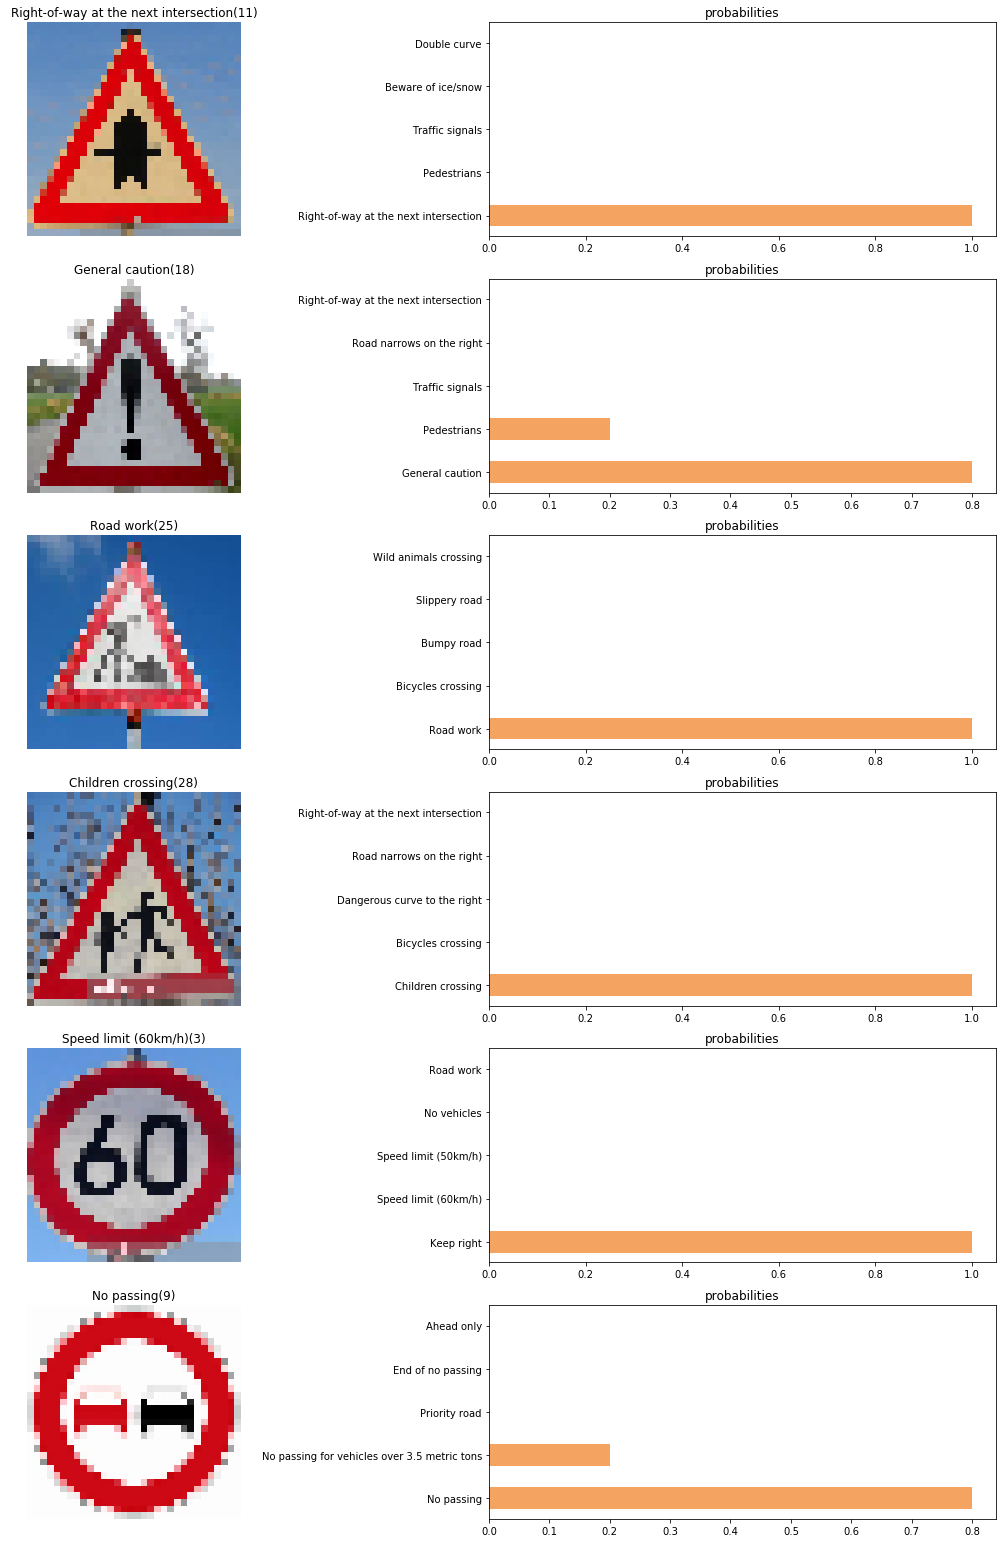

In [32]:
# code block 18

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    values, indices = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x:X_web, d:1.0})

print("Prediction Probabilities for web images:")
fig = plt.figure(figsize=(20, 70))
for i in range(len(imagenames)):
    a = fig.add_subplot(15, 2, i*2+1)
    plt.imshow(X_web[i])
    plt.title(signnames[y_web[i]] + "("+ str(y_web[i]) + ")")
    plt.axis('off')

    a = fig.add_subplot(15, 2, i*2+2)
    plt.hist(values[i], bins=5, align='left', normed=1,
             color='sandybrown', rwidth=0.5, orientation='horizontal', 
             range=(0,5))
    plt.yticks(range(5), [signnames[i] for i in indices[i]], 
               rotation='horizontal')
    plt.title("probabilities")
plt.show()

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 